In [5]:
# Water Management AI - Anomaly Detection Training
# Notebook 03: Anomaly Detection Model Training and Evaluation

# Import required libraries
import sys
import os
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import joblib
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
import mlflow

# Custom modules
from config import Config
from database.connection import DatabaseManager
from utils.data_processing import DataProcessor, RainfallProcessor
from ml_models.anomaly_detector import AnomalyDetector
from ml_models.model_manager import ModelManager

# Configure settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("="*60)
print("WATER MANAGEMENT AI - ANOMALY DETECTION")
print("="*60)
print("Notebook 03: ML-Based Anomaly Detection Training")
print("Author: Luis Pillaga")
print(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*60)

WATER MANAGEMENT AI - ANOMALY DETECTION
Notebook 03: ML-Based Anomaly Detection Training
Author: Luis Pillaga
Date: 2025-05-25 10:54:08


In [7]:
#1. Configuration and Data Loading

config = Config()
processed_base_path = "../data/processed/"

# Load processed data
try:
    individual_data_path = os.path.join(processed_base_path, 'individual_consumption.csv')
    merged_data_path = os.path.join(processed_base_path, 'merged_rainfall_consumption.csv')
    
    individual_data = pd.read_csv(individual_data_path)
    merged_data = pd.read_csv(merged_data_path)
    
    # Convert date columns
    individual_data['created_at'] = pd.to_datetime(individual_data['created_at'], format="mixed")
    individual_data['period_start'] = pd.to_datetime(individual_data['period_start'], format="mixed")
    individual_data['period_end'] = pd.to_datetime(individual_data['period_end'], format="mixed")
    merged_data['period_dt'] = pd.to_datetime(merged_data['period_dt'], format="mixed")
    
    print("✅ Data loaded successfully")
    print(f"📊 Individual consumption records: {len(individual_data)}")
    print(f"📊 Merged climate-consumption data: {len(merged_data)}")
    
except Exception as e:
    print(f"❌ Error loading data: {e}")
    print("Please run notebooks 01 and 02 first")
    raise

✅ Data loaded successfully
📊 Individual consumption records: 10067
📊 Merged climate-consumption data: 29


In [8]:
#2. Data Preparation and Feature Engineering

print(f"\n⚙️  DATA PREPARATION")
print("-" * 40)

# Filter data for training (remove extremely old or recent incomplete data)
training_cutoff_start = individual_data['period_start'].quantile(0.1)
training_cutoff_end = individual_data['period_start'].quantile(0.9)

training_data = individual_data[
    (individual_data['period_start'] >= training_cutoff_start) &
    (individual_data['period_start'] <= training_cutoff_end)
].copy()

print(f"Training data period: {training_cutoff_start.date()} to {training_cutoff_end.date()}")
print(f"Training records: {len(training_data)} ({len(training_data)/len(individual_data)*100:.1f}% of total)")

# Data quality checks
print(f"\n📊 DATA QUALITY CHECKS:")
print(f"  Missing consumption values: {training_data['total_consumed'].isna().sum()}")
print(f"  Negative consumption values: {(training_data['total_consumed'] < 0).sum()}")
print(f"  Zero consumption values: {(training_data['total_consumed'] == 0).sum()}")
print(f"  Missing days_billed: {training_data['days_billed'].isna().sum()}")

# Clean the data
training_data = training_data.dropna(subset=['total_consumed', 'water_meter_id'])
training_data = training_data[training_data['total_consumed'] >= 0]  # Remove negative consumption
training_data['days_billed'] = training_data['days_billed'].fillna(30)  # Default billing period

print(f"✅ Cleaned training data: {len(training_data)} records")

# Basic statistics
consumption_stats = training_data['total_consumed'].describe()
print(f"\n📈 CONSUMPTION STATISTICS:")
for stat, value in consumption_stats.items():
    print(f"  {stat}: {value:.2f} m³")



⚙️  DATA PREPARATION
----------------------------------------
Training data period: 2023-02-02 to 2025-02-01
Training records: 8666 (86.1% of total)

📊 DATA QUALITY CHECKS:
  Missing consumption values: 0
  Negative consumption values: 0
  Zero consumption values: 1696
  Missing days_billed: 0
✅ Cleaned training data: 8666 records

📈 CONSUMPTION STATISTICS:
  count: 8666.00 m³
  mean: 10.23 m³
  std: 11.97 m³
  min: 0.00 m³
  25%: 1.00 m³
  50%: 8.00 m³
  75%: 15.00 m³
  max: 464.00 m³


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



🔍 ANOMALY-FOCUSED EDA
----------------------------------------


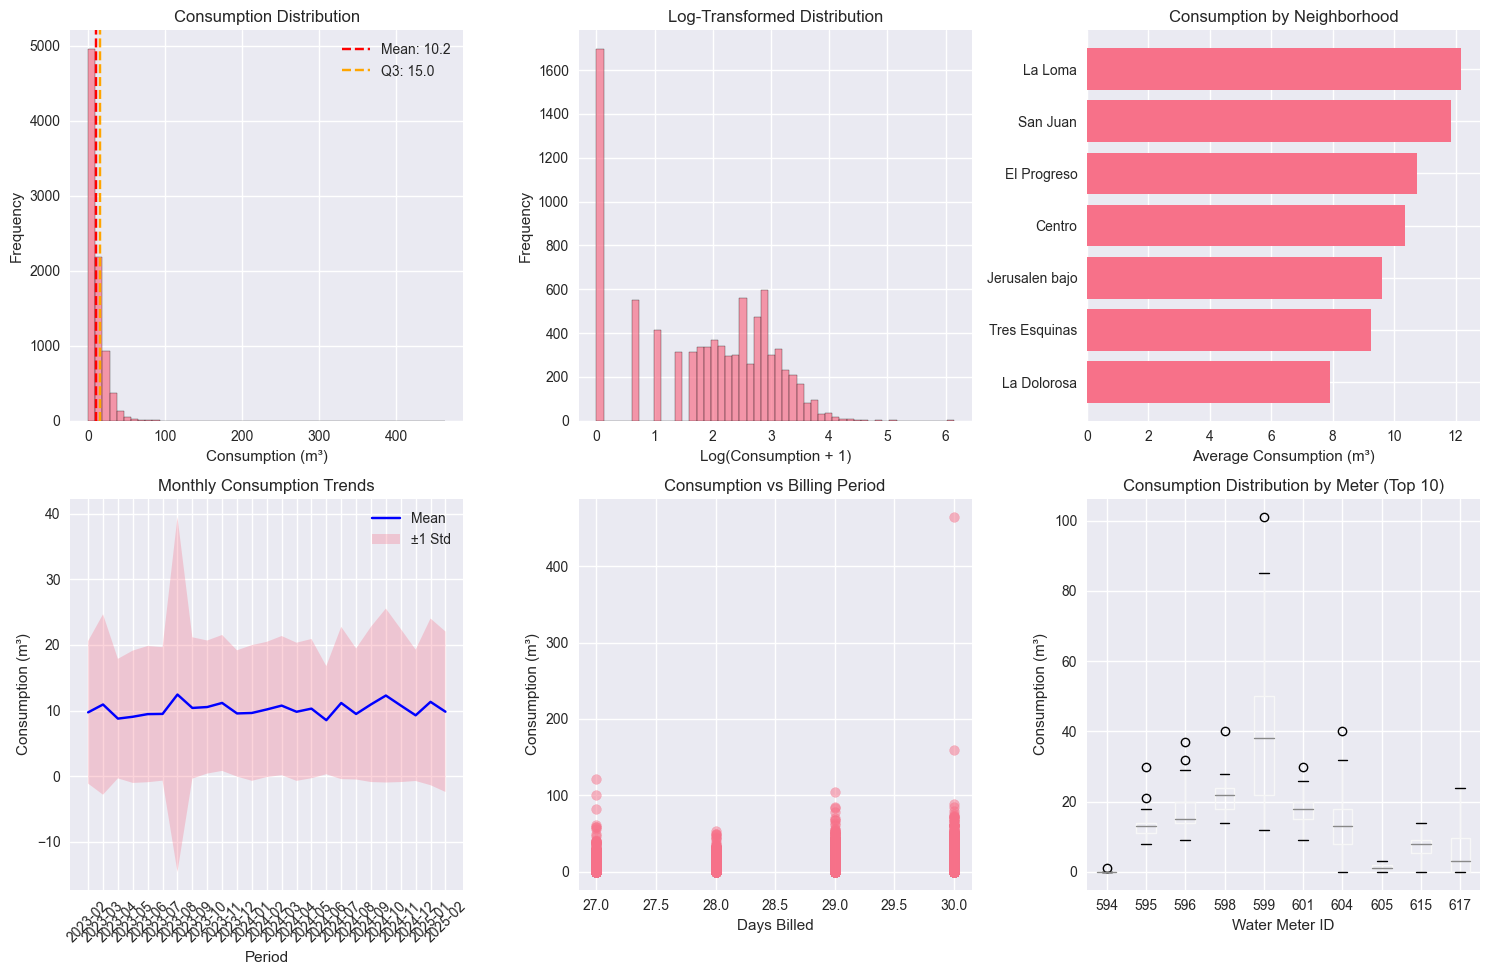


📊 STATISTICAL ANOMALY DETECTION:
  IQR method: 232 anomalies (2.7%)
  Bounds: -20.0 - 36.0 m³
  Z-score method (|z| > 3): 93 anomalies (1.1%)


In [12]:
# ## 3. Exploratory Data Analysis for Anomaly Detection

print(f"\n🔍 ANOMALY-FOCUSED EDA")
print("-" * 40)

# Analyze consumption distribution
plt.figure(figsize=(15, 10))

# 1. Overall consumption distribution
plt.subplot(2, 3, 1)
plt.hist(training_data['total_consumed'], bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Consumption (m³)')
plt.ylabel('Frequency')
plt.title('Consumption Distribution')
plt.axvline(consumption_stats['mean'], color='red', linestyle='--', label=f'Mean: {consumption_stats["mean"]:.1f}')
plt.axvline(consumption_stats['75%'], color='orange', linestyle='--', label=f'Q3: {consumption_stats["75%"]:.1f}')
plt.legend()

# 2. Log-scale distribution
plt.subplot(2, 3, 2)
plt.hist(np.log1p(training_data['total_consumed']), bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Log(Consumption + 1)')
plt.ylabel('Frequency')
plt.title('Log-Transformed Distribution')

# 3. Consumption by neighborhood
plt.subplot(2, 3, 3)
neighborhood_consumption = training_data.groupby('neighborhood_name')['total_consumed'].mean().sort_values()
plt.barh(range(len(neighborhood_consumption)), neighborhood_consumption.values)
plt.yticks(range(len(neighborhood_consumption)), neighborhood_consumption.index)
plt.xlabel('Average Consumption (m³)')
plt.title('Consumption by Neighborhood')

# 4. Time series of consumption
plt.subplot(2, 3, 4)
monthly_consumption = training_data.groupby(training_data['period_start'].dt.to_period('M'))['total_consumed'].agg(['mean', 'std'])
plt.plot(monthly_consumption.index.astype(str), monthly_consumption['mean'], 'b-', label='Mean')
plt.fill_between(monthly_consumption.index.astype(str), 
                monthly_consumption['mean'] - monthly_consumption['std'],
                monthly_consumption['mean'] + monthly_consumption['std'],
                alpha=0.3, label='±1 Std')
plt.xlabel('Period')
plt.ylabel('Consumption (m³)')
plt.title('Monthly Consumption Trends')
plt.xticks(rotation=45)
plt.legend()

# 5. Consumption vs days billed
plt.subplot(2, 3, 5)
plt.scatter(training_data['days_billed'], training_data['total_consumed'], alpha=0.5)
plt.xlabel('Days Billed')
plt.ylabel('Consumption (m³)')
plt.title('Consumption vs Billing Period')

# 6. Box plot by meter (sample of meters)
plt.subplot(2, 3, 6)
sample_meters = training_data['water_meter_id'].value_counts().head(10).index
sample_data = training_data[training_data['water_meter_id'].isin(sample_meters)]
sample_data.boxplot(column='total_consumed', by='water_meter_id', ax=plt.gca())
plt.xlabel('Water Meter ID')
plt.ylabel('Consumption (m³)')
plt.title('Consumption Distribution by Meter (Top 10)')
plt.suptitle('')  # Remove automatic title

plt.tight_layout()
plt.show()

# Identify potential anomalies using statistical methods
print(f"\n📊 STATISTICAL ANOMALY DETECTION:")

# IQR method
Q1 = training_data['total_consumed'].quantile(0.25)
Q3 = training_data['total_consumed'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

statistical_anomalies = training_data[
    (training_data['total_consumed'] < lower_bound) | 
    (training_data['total_consumed'] > upper_bound)
]

print(f"  IQR method: {len(statistical_anomalies)} anomalies ({len(statistical_anomalies)/len(training_data)*100:.1f}%)")
print(f"  Bounds: {lower_bound:.1f} - {upper_bound:.1f} m³")

# Z-score method
z_scores = np.abs((training_data['total_consumed'] - training_data['total_consumed'].mean()) / training_data['total_consumed'].std())
z_anomalies = training_data[z_scores > 3]
print(f"  Z-score method (|z| > 3): {len(z_anomalies)} anomalies ({len(z_anomalies)/len(training_data)*100:.1f}%)")


In [13]:
#4. Initialize Anomaly Detection Models

print(f"\n🤖 MODEL INITIALIZATION")
print("-" * 40)

# Initialize MLflow
model_manager = ModelManager(config.MLFLOW_TRACKING_URI, config.MLFLOW_EXPERIMENT_NAME)

# Initialize anomaly detector with different contamination rates
contamination_rates = [0.05, 0.10, 0.15]
detectors = {}

for contamination in contamination_rates:
    detector = AnomalyDetector(contamination=contamination, random_state=42)
    detectors[contamination] = detector
    print(f"✅ Initialized detector with contamination rate: {contamination}")


INFO:ml_models.model_manager:Created new MLflow experiment: junta_analytics



🤖 MODEL INITIALIZATION
----------------------------------------
✅ Initialized detector with contamination rate: 0.05
✅ Initialized detector with contamination rate: 0.1
✅ Initialized detector with contamination rate: 0.15


In [14]:
#5. Model Training and Evaluation

print(f"\n🎯 MODEL TRAINING")
print("-" * 40)

training_results = {}

for contamination, detector in detectors.items():
    print(f"\n--- Training with contamination rate: {contamination} ---")
    
    try:
        # Train the model
        results = detector.train(
            training_data=training_data,
            climate_data=merged_data,
            use_synthetic_anomalies=True
        )
        
        training_results[contamination] = results
        
        # Print training metrics
        print(f"✅ Training completed")
        print(f"  Features used: {results['features_used']}")
        print(f"  Training samples: {results['training_samples']}")
        print(f"  Detected anomalies: {results['detected_anomalies_train']}")
        print(f"  Anomaly rate: {results['anomaly_rate_train']:.1%}")
        
        if 'precision' in results:
            print(f"  Validation metrics:")
            print(f"    Precision: {results['precision']:.3f}")
            print(f"    Recall: {results['recall']:.3f}")
            print(f"    F1-score: {results['f1_score']:.3f}")
            print(f"    AUC: {results['auc_score']:.3f}")
        
    except Exception as e:
        print(f"❌ Training failed: {e}")
        continue

INFO:ml_models.anomaly_detector:Starting anomaly detector training...
INFO:ml_models.anomaly_detector:Created 433 synthetic anomalies (5.0%)



🎯 MODEL TRAINING
----------------------------------------

--- Training with contamination rate: 0.05 ---


INFO:ml_models.anomaly_detector:Validation metrics - Precision: 0.195, Recall: 0.192, F1: 0.194, AUC: 0.719
INFO:ml_models.anomaly_detector:Training completed. Detected 304 anomalies (5.0%)
INFO:ml_models.anomaly_detector:Starting anomaly detector training...
INFO:ml_models.anomaly_detector:Created 433 synthetic anomalies (5.0%)


✅ Training completed
  Features used: 11
  Training samples: 6066
  Detected anomalies: 304
  Anomaly rate: 5.0%
  Validation metrics:
    Precision: 0.195
    Recall: 0.192
    F1-score: 0.194
    AUC: 0.719

--- Training with contamination rate: 0.1 ---


INFO:ml_models.anomaly_detector:Validation metrics - Precision: 0.169, Recall: 0.331, F1: 0.223, AUC: 0.719
INFO:ml_models.anomaly_detector:Training completed. Detected 607 anomalies (10.0%)
INFO:ml_models.anomaly_detector:Starting anomaly detector training...
INFO:ml_models.anomaly_detector:Created 433 synthetic anomalies (5.0%)


✅ Training completed
  Features used: 11
  Training samples: 6066
  Detected anomalies: 607
  Anomaly rate: 10.0%
  Validation metrics:
    Precision: 0.169
    Recall: 0.331
    F1-score: 0.223
    AUC: 0.719

--- Training with contamination rate: 0.15 ---


INFO:ml_models.anomaly_detector:Validation metrics - Precision: 0.151, Recall: 0.454, F1: 0.226, AUC: 0.719
INFO:ml_models.anomaly_detector:Training completed. Detected 910 anomalies (15.0%)


✅ Training completed
  Features used: 11
  Training samples: 6066
  Detected anomalies: 910
  Anomaly rate: 15.0%
  Validation metrics:
    Precision: 0.151
    Recall: 0.454
    F1-score: 0.226
    AUC: 0.719



📊 MODEL COMPARISON
----------------------------------------
Model performance comparison:
   contamination  training_samples  features_used  anomaly_rate  precision  \
0           0.05              6066             11          0.05      0.195   
1           0.10              6066             11          0.10      0.169   
2           0.15              6066             11          0.15      0.151   

   recall  f1_score  auc_score  
0   0.192     0.194      0.719  
1   0.331     0.223      0.719  
2   0.454     0.226      0.719  

🏆 Best model: contamination rate = 0.15


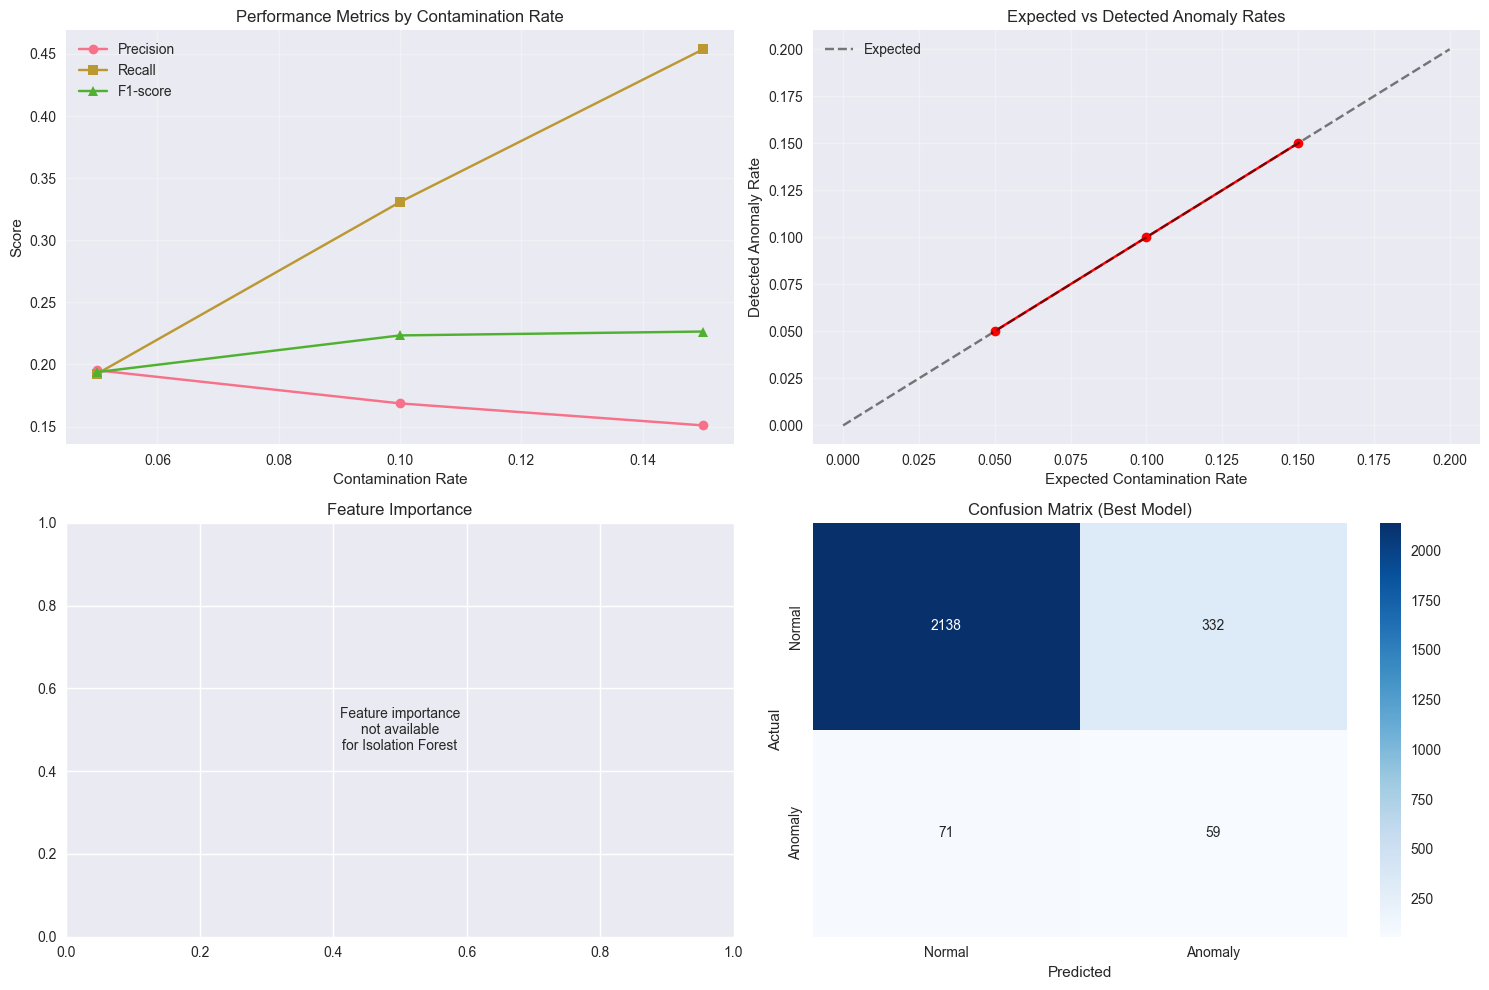

In [15]:
#6. Model Comparison and Selection

print(f"\n📊 MODEL COMPARISON")
print("-" * 40)

if training_results:
    # Create comparison dataframe
    comparison_data = []
    for contamination, results in training_results.items():
        comparison_data.append({
            'contamination': contamination,
            'training_samples': results['training_samples'],
            'features_used': results['features_used'],
            'anomaly_rate': results['anomaly_rate_train'],
            'precision': results.get('precision', 0),
            'recall': results.get('recall', 0),
            'f1_score': results.get('f1_score', 0),
            'auc_score': results.get('auc_score', 0)
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print("Model performance comparison:")
    print(comparison_df.round(3))
    
    # Select best model based on F1-score
    if 'f1_score' in comparison_df.columns and comparison_df['f1_score'].max() > 0:
        best_contamination = comparison_df.loc[comparison_df['f1_score'].idxmax(), 'contamination']
        print(f"\n🏆 Best model: contamination rate = {best_contamination}")
    else:
        best_contamination = 0.10  # Default
        print(f"\n🎯 Using default contamination rate: {best_contamination}")
    
    best_detector = detectors[best_contamination]
    
    # Visualize model performance
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Performance metrics by contamination rate
    axes[0, 0].plot(comparison_df['contamination'], comparison_df['precision'], 'o-', label='Precision')
    axes[0, 0].plot(comparison_df['contamination'], comparison_df['recall'], 's-', label='Recall')
    axes[0, 0].plot(comparison_df['contamination'], comparison_df['f1_score'], '^-', label='F1-score')
    axes[0, 0].set_xlabel('Contamination Rate')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].set_title('Performance Metrics by Contamination Rate')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Anomaly rate vs contamination rate
    axes[0, 1].plot(comparison_df['contamination'], comparison_df['anomaly_rate'], 'ro-')
    axes[0, 1].plot([0, 0.2], [0, 0.2], 'k--', alpha=0.5, label='Expected')
    axes[0, 1].set_xlabel('Expected Contamination Rate')
    axes[0, 1].set_ylabel('Detected Anomaly Rate')
    axes[0, 1].set_title('Expected vs Detected Anomaly Rates')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Feature importance (if available)
    if hasattr(best_detector.model, 'feature_importances_'):
        feature_names = best_detector.feature_columns
        importances = best_detector.model.feature_importances_
        
        # Sort features by importance
        sorted_idx = np.argsort(importances)[::-1]
        
        axes[1, 0].bar(range(len(importances)), importances[sorted_idx])
        axes[1, 0].set_xlabel('Feature Index')
        axes[1, 0].set_ylabel('Importance')
        axes[1, 0].set_title('Feature Importance (Best Model)')
        axes[1, 0].set_xticks(range(len(importances)))
        axes[1, 0].set_xticklabels([feature_names[i] for i in sorted_idx], rotation=45, ha='right')
    else:
        axes[1, 0].text(0.5, 0.5, 'Feature importance\nnot available\nfor Isolation Forest', 
                       ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 0].set_title('Feature Importance')
    
    # Confusion matrix for best model
    if 'confusion_matrix' in training_results[best_contamination]:
        cm = np.array(training_results[best_contamination]['confusion_matrix'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
        axes[1, 1].set_xlabel('Predicted')
        axes[1, 1].set_ylabel('Actual')
        axes[1, 1].set_title(f'Confusion Matrix (Best Model)')
        axes[1, 1].set_xticklabels(['Normal', 'Anomaly'])
        axes[1, 1].set_yticklabels(['Normal', 'Anomaly'])
    else:
        axes[1, 1].text(0.5, 0.5, 'Confusion matrix\nnot available', 
                       ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Confusion Matrix')
    
    plt.tight_layout()
    plt.show()


🧪 REAL-WORLD TESTING
----------------------------------------
Testing on 709 recent records...
Test results:
  Total samples: 709
  Detected anomalies: 709
  Anomaly rate: 100.0%

Top 5 anomalous readings:
  Meter 471: 93.0 m³ (confidence: 100.0%, neighborhood: Tres Esquinas)
  Meter 456: 91.0 m³ (confidence: 97.4%, neighborhood: Jerusalen bajo)
  Meter 1050: 88.0 m³ (confidence: 94.7%, neighborhood: Centro)
  Meter 1054: 88.0 m³ (confidence: 90.2%, neighborhood: Jerusalen bajo)
  Meter 599: 72.0 m³ (confidence: 81.8%, neighborhood: Centro)


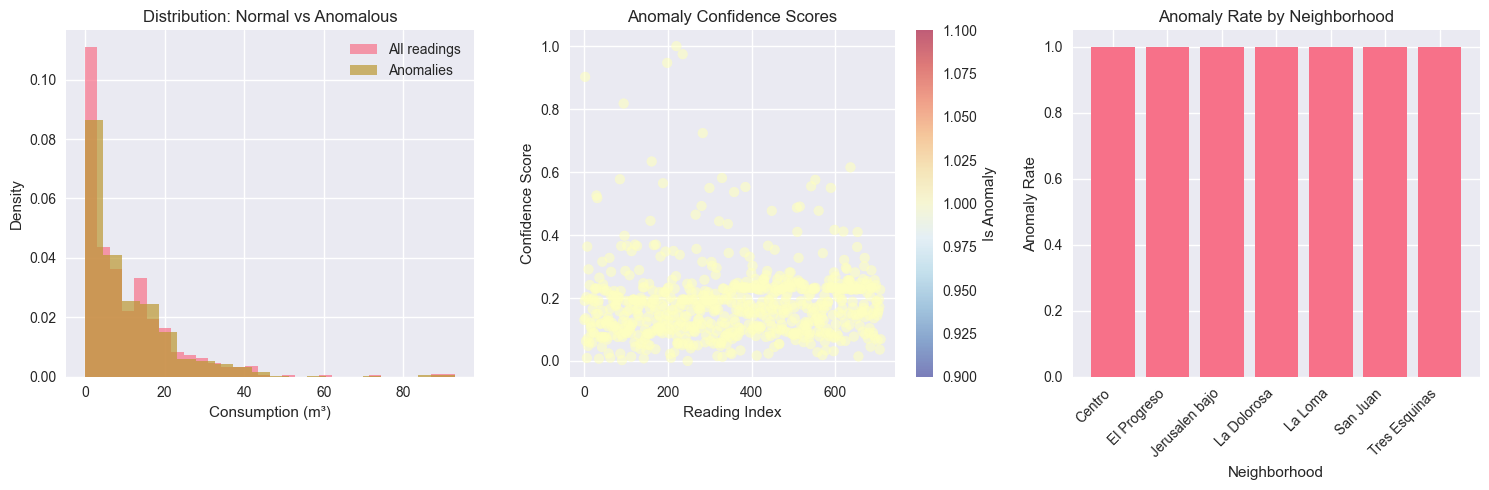

In [16]:
#7. Real-World Testing

print(f"\n🧪 REAL-WORLD TESTING")
print("-" * 40)

if best_detector and best_detector.is_trained:
    # Test on recent data (not used in training)
    test_data = individual_data[individual_data['period_start'] > training_cutoff_end].copy()
    
    if len(test_data) > 0:
        print(f"Testing on {len(test_data)} recent records...")
        
        # Make predictions on test data
        test_predictions = best_detector.predict(test_data, merged_data)
        
        print(f"Test results:")
        print(f"  Total samples: {test_predictions['total_samples']}")
        print(f"  Detected anomalies: {test_predictions['detected_anomalies']}")
        print(f"  Anomaly rate: {test_predictions['anomaly_rate']:.1%}")
        
        # Analyze detected anomalies
        anomaly_mask = test_predictions['predictions']
        confidence_scores = test_predictions['confidence_scores']
        
        if sum(anomaly_mask) > 0:
            anomalous_readings = test_data[anomaly_mask].copy()
            anomalous_readings['confidence'] = [confidence_scores[i] for i, is_anomaly in enumerate(anomaly_mask) if is_anomaly]
            
            print(f"\nTop 5 anomalous readings:")
            top_anomalies = anomalous_readings.nlargest(5, 'confidence')
            for _, row in top_anomalies.iterrows():
                print(f"  Meter {row['water_meter_id']}: {row['total_consumed']:.1f} m³ "
                      f"(confidence: {row['confidence']:.1%}, neighborhood: {row['neighborhood_name']})")
            
            # Visualize anomalies
            plt.figure(figsize=(15, 5))
            
            plt.subplot(1, 3, 1)
            plt.hist(test_data['total_consumed'], bins=30, alpha=0.7, label='All readings', density=True)
            plt.hist(anomalous_readings['total_consumed'], bins=20, alpha=0.7, label='Anomalies', density=True)
            plt.xlabel('Consumption (m³)')
            plt.ylabel('Density')
            plt.title('Distribution: Normal vs Anomalous')
            plt.legend()
            
            plt.subplot(1, 3, 2)
            plt.scatter(range(len(confidence_scores)), confidence_scores, alpha=0.6, c=anomaly_mask, cmap='RdYlBu_r')
            plt.xlabel('Reading Index')
            plt.ylabel('Confidence Score')
            plt.title('Anomaly Confidence Scores')
            plt.colorbar(label='Is Anomaly')
            
            plt.subplot(1, 3, 3)
            neighborhood_anomaly_rate = anomalous_readings.groupby('neighborhood_name').size() / test_data.groupby('neighborhood_name').size()
            neighborhood_anomaly_rate = neighborhood_anomaly_rate.fillna(0).sort_values(ascending=False)
            plt.bar(range(len(neighborhood_anomaly_rate)), neighborhood_anomaly_rate.values)
            plt.xlabel('Neighborhood')
            plt.ylabel('Anomaly Rate')
            plt.title('Anomaly Rate by Neighborhood')
            plt.xticks(range(len(neighborhood_anomaly_rate)), neighborhood_anomaly_rate.index, rotation=45, ha='right')
            
            plt.tight_layout()
            plt.show()
        
        else:
            print("\nNo anomalies detected in test data")
    else:
        print("No test data available (all data used for training)")


In [17]:
#8. Individual Reading Tests

print(f"\n🔍 INDIVIDUAL READING TESTS")
print("-" * 40)

if best_detector and best_detector.is_trained:
    # Test some specific scenarios
    test_scenarios = [
        {
            'name': 'Normal consumption',
            'water_meter_id': training_data['water_meter_id'].iloc[0],
            'previous_reading': 1000,
            'current_reading': 1025,
            'days_billed': 30
        },
        {
            'name': 'High consumption',
            'water_meter_id': training_data['water_meter_id'].iloc[0],
            'previous_reading': 1000,
            'current_reading': 1150,
            'days_billed': 30
        },
        {
            'name': 'Very low consumption',
            'water_meter_id': training_data['water_meter_id'].iloc[0],
            'previous_reading': 1000,
            'current_reading': 1005,
            'days_billed': 30
        },
        {
            'name': 'Extremely high consumption',
            'water_meter_id': training_data['water_meter_id'].iloc[0],
            'previous_reading': 1000,
            'current_reading': 1300,
            'days_billed': 30
        }
    ]
    
    print("Testing individual reading scenarios:")
    
    for scenario in test_scenarios:
        try:
            result = best_detector.detect_single_reading(
                water_meter_id=scenario['water_meter_id'],
                current_reading=scenario['current_reading'],
                previous_reading=scenario['previous_reading'],
                days_billed=scenario['days_billed'],
                historical_data=training_data
            )
            
            consumption = scenario['current_reading'] - scenario['previous_reading']
            status = "🚨 ANOMALY" if result['is_anomaly'] else "✅ NORMAL"
            
            print(f"\n  {scenario['name']} ({consumption} m³): {status}")
            print(f"    Confidence: {result['confidence']:.1%}")
            print(f"    Reason: {result['reason']}")
            print(f"    Recommendation: {result['recommendation']}")
            
        except Exception as e:
            print(f"\n  {scenario['name']}: ❌ Error - {e}")


🔍 INDIVIDUAL READING TESTS
----------------------------------------
Testing individual reading scenarios:

  Normal consumption: ❌ Error - X has 9 features, but StandardScaler is expecting 11 features as input.

  High consumption: ❌ Error - X has 9 features, but StandardScaler is expecting 11 features as input.

  Very low consumption: ❌ Error - X has 9 features, but StandardScaler is expecting 11 features as input.

  Extremely high consumption: ❌ Error - X has 9 features, but StandardScaler is expecting 11 features as input.


In [18]:
#9. Model Persistence

print(f"\n💾 MODEL PERSISTENCE")
print("-" * 40)

if best_detector and best_detector.is_trained:
    try:
        # Save the best model
        model_filename = f"anomaly_detector_best_{datetime.now().strftime('%Y%m%d_%H%M%S')}.joblib"
        model_path = os.path.join(config.MODELS_PATH, model_filename)
        
        best_detector.save_model(model_path)
        print(f"✅ Model saved: {model_path}")
        
        # Save model with MLflow
        run_id = model_manager.train_anomaly_detector(
            training_data,
            climate_data=merged_data,
            model_params={
                'contamination': best_contamination,
                'random_state': 42
            }
        )
        
        print(f"✅ Model logged to MLflow: run_id = {run_id}")
        
        # Export model information
        model_info_path = os.path.join(config.PROCESSED_DATA_PATH, 'anomaly_model_info.json')
        model_manager.export_model_info(model_info_path)
        print(f"✅ Model info exported: {model_info_path}")
        
    except Exception as e:
        print(f"❌ Error saving model: {e}")

INFO:ml_models.anomaly_detector:Model saved to ./data/models/anomaly_detector_best_20250525_110350.joblib
INFO:ml_models.anomaly_detector:Starting anomaly detector training...
INFO:ml_models.anomaly_detector:Created 433 synthetic anomalies (5.0%)



💾 MODEL PERSISTENCE
----------------------------------------
✅ Model saved: ./data/models/anomaly_detector_best_20250525_110350.joblib


INFO:ml_models.anomaly_detector:Validation metrics - Precision: 0.151, Recall: 0.454, F1: 0.226, AUC: 0.719
INFO:ml_models.anomaly_detector:Training completed. Detected 910 anomalies (15.0%)
INFO:ml_models.anomaly_detector:Model saved to anomaly_detector_20250525_110350.joblib
ERROR:ml_models.model_manager:Error training anomaly detector: "['consumption_zscore', 'consumption_ratio', 'neighborhood_zscore', 'month_sin', 'month_cos', 'meter_count', 'period_rainfall', 'rainfall_consumption_interaction'] not in index"


❌ Error saving model: "['consumption_zscore', 'consumption_ratio', 'neighborhood_zscore', 'month_sin', 'month_cos', 'meter_count', 'period_rainfall', 'rainfall_consumption_interaction'] not in index"


In [19]:
#10. Summary and Recommendations

print(f"\n📋 TRAINING SUMMARY")
print("=" * 40)

if training_results:
    best_results = training_results[best_contamination]
    
    print(f"🎯 BEST MODEL PERFORMANCE:")
    print(f"  • Contamination rate: {best_contamination}")
    print(f"  • Training samples: {best_results['training_samples']:,}")
    print(f"  • Features used: {best_results['features_used']}")
    
    if 'precision' in best_results:
        print(f"  • Validation metrics:")
        print(f"    - Precision: {best_results['precision']:.3f}")
        print(f"    - Recall: {best_results['recall']:.3f}")
        print(f"    - F1-score: {best_results['f1_score']:.3f}")
        print(f"    - AUC: {best_results['auc_score']:.3f}")
    
    print(f"\n📊 FEATURE ANALYSIS:")
    feature_names = best_results['feature_names']
    print(f"  • Total features: {len(feature_names)}")
    print(f"  • Key features: {', '.join(feature_names[:5])}")
    
    print(f"\n🎯 DEPLOYMENT READINESS:")
    deployment_score = 0
    
    if best_results.get('f1_score', 0) > 0.7:
        print("  ✅ High F1-score (>0.7)")
        deployment_score += 1
    elif best_results.get('f1_score', 0) > 0.5:
        print("  ⚠️  Moderate F1-score (0.5-0.7)")
        deployment_score += 0.5
    else:
        print("  ❌ Low F1-score (<0.5)")
    
    if best_results.get('auc_score', 0) > 0.8:
        print("  ✅ High AUC score (>0.8)")
        deployment_score += 1
    elif best_results.get('auc_score', 0) > 0.6:
        print("  ⚠️  Moderate AUC score (0.6-0.8)")
        deployment_score += 0.5
    else:
        print("  ❌ Low AUC score (<0.6)")
    
    if abs(best_results['anomaly_rate_train'] - best_contamination) < 0.02:
        print("  ✅ Anomaly rate matches expectation")
        deployment_score += 1
    else:
        print("  ⚠️  Anomaly rate deviates from expectation")
        deployment_score += 0.5
    
    print(f"\n📈 DEPLOYMENT SCORE: {deployment_score}/3.0")
    
    if deployment_score >= 2.5:
        print("  🚀 Model ready for production deployment")
    elif deployment_score >= 1.5:
        print("  ⚠️  Model suitable for testing/staging environment")
    else:
        print("  ❌ Model needs improvement before deployment")
    
    print(f"\n🔧 RECOMMENDATIONS:")
    
    if best_results.get('f1_score', 0) < 0.7:
        print("  • Consider tuning contamination rate")
        print("  • Add more relevant features")
        print("  • Collect more training data")
    
    if len(feature_names) > 15:
        print("  • Consider feature selection to reduce overfitting")
    
    print("  • Monitor model performance in production")
    print("  • Retrain periodically with new data")
    print("  • Set up automated anomaly alerts")

else:
    print("❌ No models were successfully trained")


📋 TRAINING SUMMARY
🎯 BEST MODEL PERFORMANCE:
  • Contamination rate: 0.15
  • Training samples: 6,066
  • Features used: 11
  • Validation metrics:
    - Precision: 0.151
    - Recall: 0.454
    - F1-score: 0.226
    - AUC: 0.719

📊 FEATURE ANALYSIS:
  • Total features: 11
  • Key features: total_consumed, consumption_per_day, consumption_zscore, consumption_ratio, neighborhood_zscore

🎯 DEPLOYMENT READINESS:
  ❌ Low F1-score (<0.5)
  ⚠️  Moderate AUC score (0.6-0.8)
  ✅ Anomaly rate matches expectation

📈 DEPLOYMENT SCORE: 1.5/3.0
  ⚠️  Model suitable for testing/staging environment

🔧 RECOMMENDATIONS:
  • Consider tuning contamination rate
  • Add more relevant features
  • Collect more training data
  • Monitor model performance in production
  • Retrain periodically with new data
  • Set up automated anomaly alerts
